2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

Module import

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [10]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return 1 / (1 + tf.math.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W):
    return neural_network(W, 1)

def EC_predict(W, x, lamb, n):
    return f(net_out(W)*x**(n+1), lamb)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

def EC_d_y(W, x, n):
    return (n+1)*(x**n)*net_out(W) + x**(n+1)* d_net_out(W, x)

Parameter

In [18]:
# 최대 x 범위 : 0 <= x < x_max, lambda 값
x_max = 1
x = tf.Variable(np.array([[i/100] for i in range(0, x_max * 100, 1)], dtype = np.float32))
lamb = -1

# 차수, weight 개수
n = 4
w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

# EC, Weight 개수
EC_n = 10
# w = [[1, EC_n], [EC_n, 1]]
W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

# 변화 w 값, loss 저장
w_trace = [np.append(np.array(w.numpy()), net_out(W).numpy())]
loss_trace = []

#  학습률 조정
learning_rate = 0.01
# EPOCH = 100

# 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
Epoch = 0
target_loss = 0.0001

Train

In [19]:
# y' = f(y, t)를 만족하는 y 찾는 과정
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
EC_optimizer = keras.optimizers.SGD(learning_rate=1e-3)
from collections import deque


# 학습 과정
while True:
    Epoch += 1
    dq = deque([1,2,3], 3)
    for x_unit in x:
        with tf.GradientTape() as tape:
            # 예측 값
            predict = f(y(x_unit, w, n), lamb)
            # y' = f(y, t)
            loss = tf.square(predict - yprime(x_unit, w, n)) + tf.square(EC_predict(W, x_unit, lamb, n) - EC_d_y(W, x_unit, n))
            loss_trace.append(float(loss))
            dq.append(float(loss))
            # # 오차
            w_trace.append(np.append(np.array(w.numpy()), net_out(W).numpy()))
            # w = tf.Variable(w - learning_rate*gradients)
        [gradients, EC_gradients] = tape.gradient(loss, [w, W])
        optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
    dif = float(loss) < target_loss
    if dif:
        break
    if dif and round(dq[0], 15) >= round(dq[2], 15):
            break
    if Epoch % 1000 == 0:
        # print('Epoch : {}, Loss : {:.4f}'.format(Epoch, loss))
        print(Epoch, loss)
print(Epoch, loss)

205 tf.Tensor([[9.8290686e-05]], shape=(1, 1), dtype=float32)


weight 값 출력

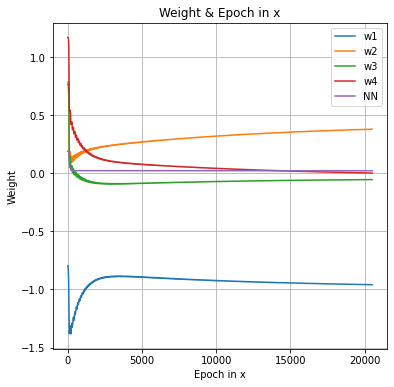

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Weight & Epoch in x')
ax.set_xlabel('Epoch in x')
ax.set_ylabel('Weight')
ax.plot(w_trace, label = ['w1', 'w2', 'w3', 'w4', 'NN'])
ax.tick_params(labelsize=10)
ax.legend(fontsize=10)
ax.grid()

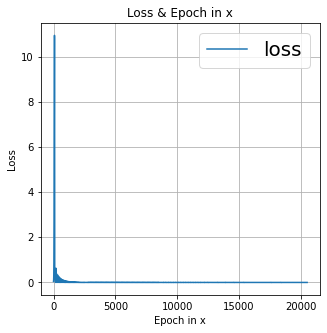

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Loss & Epoch in x')
ax.set_xlabel('Epoch in x')
ax.set_ylabel('Loss')
ax.plot(loss_trace, label = 'loss')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

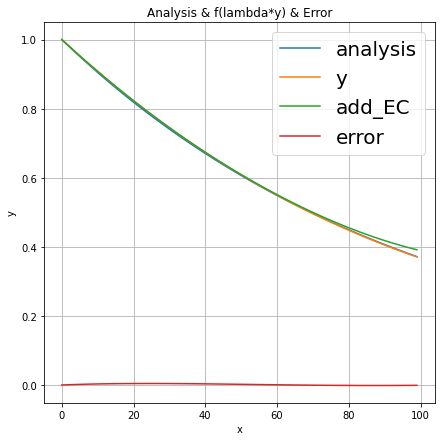

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

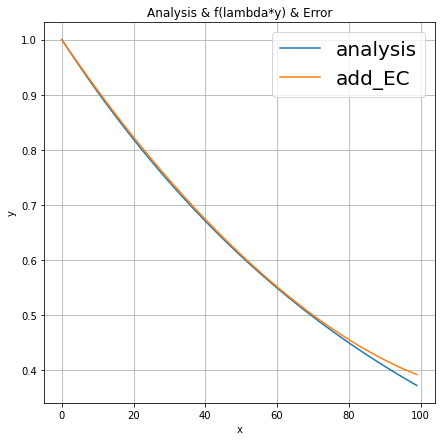

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
# ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

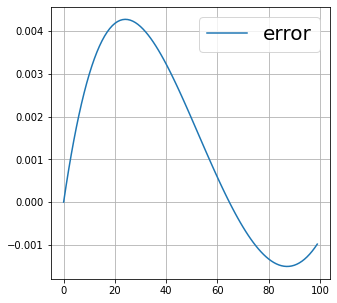

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

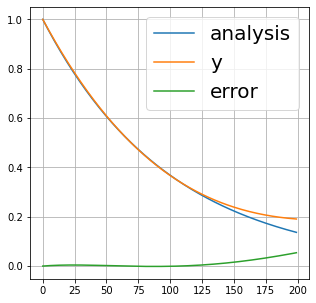

In [26]:
x = tf.Variable([0.01*n for n in range(200)], dtype = tf.float32)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

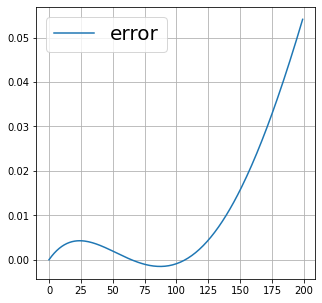

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [ ]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정


In [ ]:
print(Epoch)

518


In [ ]:
print(loss)

tf.Tensor([5.9604645e-08], shape=(1,), dtype=float32)


add EC

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

import autograd.numpy.random as npr

W = [npr.randn(1, 10), npr.randn(10, 1)]

def loss_function(W, x, yhat):
    loss_sum = 0
    for i in range(0,len(x)):
        net_out = neural_network(W, x[i])[0][0]
        predict = f(net_out*x[i]**(n+1), lamb)

        d_net_out = d_neural_network_dx(W, x[i])[0][0]
        d_y = (n+1)*(x[i]**n)*net_out + x[i]**(n+1)* d_net_out

        err_sqr = (d_y - predict)**2
        loss_sum += err_sqr
    return loss_sum

# # W = EC의 weight, lamb = 초기값, n = 차수
# def loss_function(W, x):
#     loss_sum = 0
#     for x_unit in x:
#         # predict = lamb*(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + NN*(x**5))
#         predict = f(y(x_unit, w, n), lamb) + lamb*neural_network(W, x_unit)*x_unit**5
#         # d_psy = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + 5*NN*(x**4) + d_NN*(x**5)
#         d_psy = yprime(x_unit, w, n) + 5*neural_network(W, x_unit)*x_unit**4 + d_neural_network_dx(W, x_unit, k=1)*x_unit**5

#         error_sqrare = (predict - d_psy)**2

#         loss_sum += error_sqrare
#     return float(loss_sum)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

import autograd.numpy.random as npr

W = [npr.randn(1, 10), npr.randn(10, 1)]

def loss_function(W, x, yhat):
    loss_sum = 0
    for i in range(0,len(x)):
        net_out = neural_network(W, x[i])[0][0]
        predict = f(net_out*x[i]**(n+1), lamb)

        d_net_out = d_neural_network_dx(W, x[i])[0][0]
        d_y = (n+1)*(x[i]**n)*net_out + x[i]**(n+1)* d_net_out

        err_sqr = (d_y - predict)**2
        loss_sum += err_sqr
    return loss_sum

# # W = EC의 weight, lamb = 초기값, n = 차수
# def loss_function(W, x):
#     loss_sum = 0
#     for x_unit in x:
#         # predict = lamb*(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + NN*(x**5))
#         predict = f(y(x_unit, w, n), lamb) + lamb*neural_network(W, x_unit)*x_unit**5
#         # d_psy = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + 5*NN*(x**4) + d_NN*(x**5)
#         d_psy = yprime(x_unit, w, n) + 5*neural_network(W, x_unit)*x_unit**4 + d_neural_network_dx(W, x_unit, k=1)*x_unit**5

#         error_sqrare = (predict - d_psy)**2

#         loss_sum += error_sqrare
#     return float(loss_sum)

In [ ]:
LR = 0.001

nx = 11
Tfinal=1
dx = Tfinal / (nx-1)

x_space = np.linspace(0, Tfinal, nx)    

import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive

for _ in range(5000):
    # print(loss_function(W, x_space, lamb, n))
    loss_grad =  grad(loss_function)(W, x_space, f(y(x_space, w, n), lamb))
    
    W[0] = W[0] - LR * loss_grad[0]
    W[1] = W[1] - LR * loss_grad[1]


[array([0.04100409]), array([0.03334122]), array([0.02609898]), array([0.01965342]), array([0.01429954]), array([0.01022887]), array([0.00752293]), array([0.00616108]), array([0.00603849]), array([0.00698918]), array([0.00880965])]


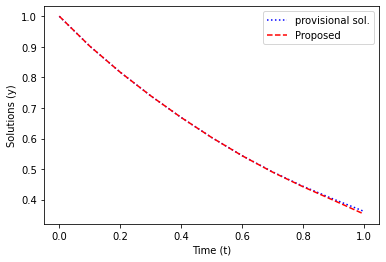

In [ ]:
# tf.print(loss_function(W, x_space,psy_fd))
res =  y(x_space, w, n) + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space]

aa= [neural_network(W, xi)[0] for xi in x_space]
print(aa)
beingsaved = plt.figure()
# plt.plot(x_space, anal(x_space,lamb), 'g-',label='analytic sol.') 
plt.plot(x_space, y(x_space, w, n), 'b:',label='provisional sol.')
plt.plot(x_space, res, 'r--',label='Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Solutions (y)')
#plt.yscale("log")
plt.legend()
plt.show()
#beingsaved.savefig('test3comp.eps', format='eps', dpi=1000)

In [ ]:
add_EC = y(x_space, w, n)-res

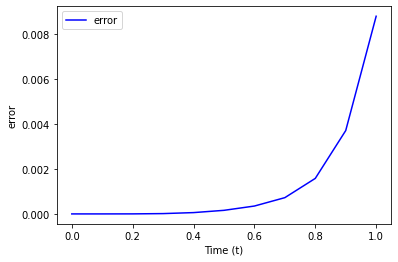

In [ ]:
plt.plot(x_space, abs(add_EC), 'b-',label='error')
plt.xlabel('Time (t)')
plt.ylabel('error')
plt.legend()
plt.show()

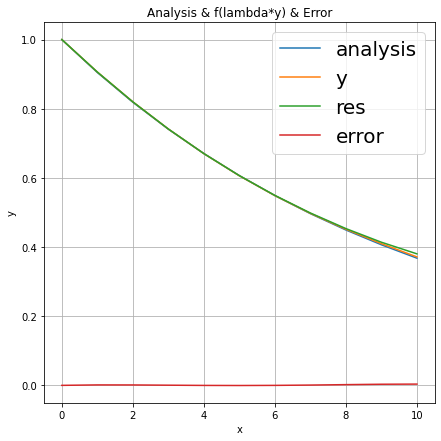

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x_space,lamb), label = 'analysis')
ax.plot(y(x_space, w, n), label = 'y')
ax.plot(res, label = 'res')
ax.plot(y(x_space, w, n) - anal(x_space,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

In [ ]:
# 최대 x 범위 : 0 <= x < x_max, lambda 값
x_max = 1
x = tf.Variable(np.array([[i/100] for i in range(0, x_max * 100, 1)], dtype = np.float32))
lamb = -1

# 차수, weight 개수
n = 5
w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

# 변화 w 값, loss 저장
w_trace = []
w_trace.append(w.numpy())
loss_trace = []

#  학습률 조정
learning_rate = 0.01
# EPOCH = 100

# 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
Epoch = 0
target_loss = 0.0000001

In [ ]:
# y' = f(y, t)를 만족하는 y 찾는 과정
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
from collections import deque


# 학습 과정
while True:
    Epoch += 1
    dq = deque([1,2,3], 3)
    for x_unit in x:
        with tf.GradientTape() as tape:
            # 예측 값
            predict = f(y(x_unit, w, n), lamb)
            # y' = f(y, t)
            loss = tf.math.sqrt(tf.square(predict - yprime(x_unit, w, n)))
            loss_trace.append(loss.numpy())
            dq.append(float(loss))
            # # 오차
            w_trace.append(w.numpy())
            # w = tf.Variable(w - learning_rate*gradients)
        dif = float(loss) < target_loss
        if dif:
            break
        gradients = tape.gradient(loss, w)
        optimizer.apply_gradients(zip([gradients], [w]))
    if dif and round(dq[0], 15) >= round(dq[2], 15):
            break
    if Epoch % 1000 == 0:
        # print('Epoch : {}, Loss : {:.4f}'.format(Epoch, loss))
        print(Epoch, loss)
print(Epoch, loss)

820 tf.Tensor([5.9604645e-08], shape=(1,), dtype=float32)


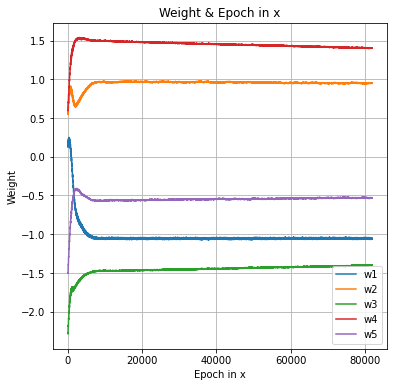

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Weight & Epoch in x')
ax.set_xlabel('Epoch in x')
ax.set_ylabel('Weight')
ax.plot(w_trace, label = ['w1', 'w2', 'w3', 'w4', 'w5'])
ax.tick_params(labelsize=10)
ax.legend(fontsize=10)
ax.grid()

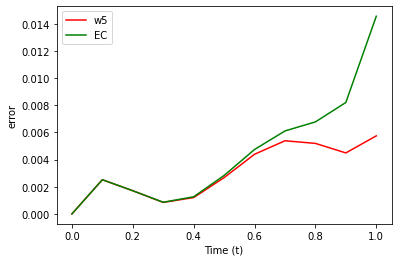

In [ ]:
plt.plot(x_space, abs(anal(x_space,lamb) - y(x_space, w, n)), 'r-',label='w5')
plt.plot(x_space, abs(anal(x_space,lamb) - res), 'g-',label='EC')
plt.xlabel('Time (t)')
plt.ylabel('error')
plt.legend()
plt.show()

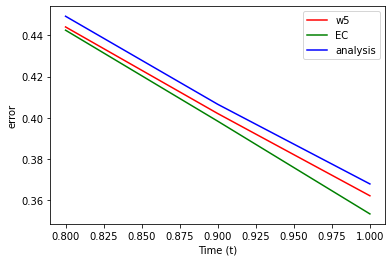

In [ ]:
plt.plot(x_space[-3:], y(x_space[-3:], w, n), 'r-',label='w5')
plt.plot(x_space[-3:], res[-3:], 'g-',label='EC')
plt.plot(x_space[-3:], anal(x_space[-3:], lamb), 'b-',label='analysis')
plt.xlabel('Time (t)')
plt.ylabel('error')
plt.legend()
plt.show()

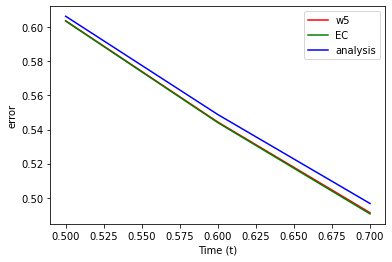

In [ ]:
plt.plot(x_space[-6:-3], y(x_space[-6:-3], w, n), 'r-',label='w5')
plt.plot(x_space[-6:-3], res[-6:-3], 'g-',label='EC')
plt.plot(x_space[-6:-3], anal(x_space[-6:-3], lamb), 'b-',label='analysis')
plt.xlabel('Time (t)')
plt.ylabel('error')
plt.legend()
plt.show()